# Qudits VS qubits


<img src="https://rqc.ru/static/RQClogo_black_ru.png" alt="drawing" height="300">

## Annotation

The following notebook implements qudits VQC and qubit VQC

Author: Artem Kuzmichev, Quantum Research Scientist, RQC

## qudit-vqc package


In [ ]:
try:
    from qubit_variational_qc import *
    from qudit_depolarization_channels import *
    from qudit_gates import *
    from qudit_variational_qc import *

except ModuleNotFoundError:
    !git clone https://github.com/artem-phys/qudits-vqc.git --quiet
    !cd qudits-vqc
    !pip install -e qudits-vqc --quiet
    print('qudits-vqc succecefully installed. Run again')
    exit()

## imports and qudit configuration


We are going to study implementation of qudits for variational circuits. Since the real device we have in FIAN is two-qudit quantim computer with d=4 (ququarts), it appears reasonable to choose this specific value

In [ ]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

from tqdm import tqdm

import cirq
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import SVGCircuit
from cirq import PauliSum

In [ ]:
d = 4
n = 2

qudits = cirq.LineQid.range(n, dimension=d)
q0, q1 = qudits

print(qudits)

[cirq.LineQid(0, dimension=4), cirq.LineQid(1, dimension=4)]


##Qubit VQC

In [ ]:
p1 = 0.001 # single qubit
p2 = 0.01 # two qubit

In [ ]:
def qubit_rot_layer(qubits_, theta_list, phi_list, with_noise=False):
    """Yields parametrized single qubit rotations"""
    for i, qid in enumerate(qubits_):
        rot = QuditRGate(0, 1, theta_list[i], phi_list[i], dimension=2)
        yield rot.on(cirq.LineQid(i, dimension=2))
        if with_noise:
            yield cirq.DepolarizingChannel(p=p1, n_qubits=1).on(qid)


def qubit_rot_zz_layer(qubits_, theta, with_noise=False):
    """Yields parametrized two qudit rotation"""
    for i in range(len(qubits_)):
        for j in range(i + 1, len(qubits_)):
            yield cirq.ZZ(qubits_[i], qubits_[j]) ** theta
            if with_noise:
                yield cirq.DepolarizingChannel(p=p2, n_qubits=2).on(qubits_[i], qubits_[j])


def qubit_one_step(qubits_, theta_list, phi_list, two_qudit_theta, with_noise=False):
    """One variational step"""
    yield qubit_rot_layer(qubits_, theta_list, phi_list, with_noise=with_noise)

    yield qubit_rot_zz_layer(qubits_, two_qudit_theta, with_noise=with_noise)


def qubit_variational_qc(tl_, pl_, tqtl_, num_layers_, num_qubits_, measurement=False, with_noise=False):

    # two_qudits
    qubits_ = cirq.LineQid.range(num_qubits_, dimension=2)
    qc = cirq.Circuit()

    # qc.append([cirq.H(q) for q in qubits_], strategy=InsertStrategy.NEW_THEN_INLINE)

    for layer in range(num_layers_):
        qc.append(qubit_one_step(qubits_, tl_[layer], pl_[layer], tqtl_[layer], with_noise=with_noise), strategy=InsertStrategy.NEW_THEN_INLINE)

    if measurement:
        qc.append(cirq.measure(*qubits_, key='qubits'))

    return qc

Qubit Variational Ansatz


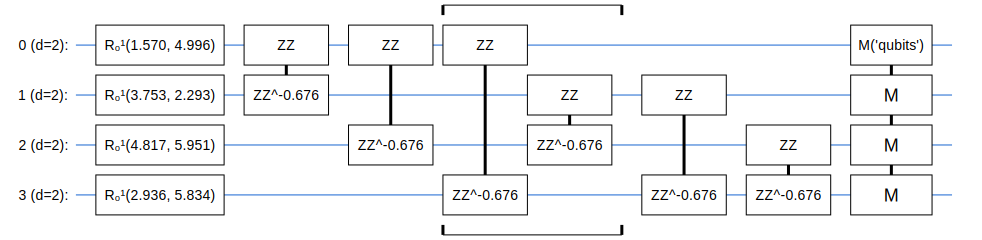

In [ ]:
num_layers = 1  # number of variational layers
num_qubits = 4
num_qubits_pairs = int((num_qubits + 1) * num_qubits / 2)

tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qubits))
pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qubits))
tqtl = np.random.uniform(low=0, high=2 * np.pi, size=num_layers)

print('Qubit Variational Ansatz')
qubit_vqc = qubit_variational_qc(tl, pl, tqtl, num_layers, num_qubits, measurement=True, with_noise=False)
SVGCircuit(qubit_vqc)

In [ ]:
simulator = cirq.Simulator()

qubit_results = simulator.run(qubit_vqc, repetitions=10)
qubit_results.histogram(key='qubits', fold_func= lambda bits: ''.join(map(str, bits)))

Counter({'0101': 3, '0111': 2, '1111': 4, '1101': 1})

In [ ]:
qubit_energy_hist = qubit_results.histogram(key='qubits')
qubit_energy_hist

Counter({5: 3, 7: 2, 15: 4, 13: 1})

##Qudit VQC


Qudit Variational Ansatz


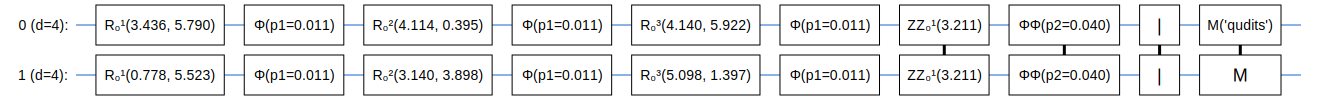

In [ ]:
num_layers = 1  # number of variational layers
num_qudits = 2
num_qudits_pairs = int((num_qudits + 1) * num_qudits / 2)

tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
tqtl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qudits_pairs))

print('Qudit Variational Ansatz')
qudit_vqc = variational_qc(tl, pl, tqtl, num_layers, num_qudits, measurement=True, with_noise=True)
SVGCircuit(qudit_vqc)

In [ ]:
tl, pl, tqtl

(array([[[3.43578457, 0.77795508],
         [4.11392869, 3.13957812],
         [4.14009486, 5.09776488]]]), array([[[5.78966949, 5.52306467],
         [0.39511407, 3.89834299],
         [5.92222177, 1.39740283]]]), array([[3.21091172, 4.60433903, 4.57002243]]))

In [ ]:
qudit_results = simulator.run(qudit_vqc, repetitions=10)
qudit_results.histogram(key='qudits', fold_func= lambda bits: ''.join(map(str, bits)))

Counter({'12': 8, '11': 2})

##Reshape pararameters list

params = [5.56104669 5.17428939 1.13671925 2.74155444 5.6084394  5.25726259
 2.13592061 3.55654438 4.89351211]

theta_list = [[5.56104669 5.17428939 1.13671925 2.74155444]]
phi_list = [[5.6084394  5.25726259 2.13592061 3.55654438]]
tqt_list = [4.89351211]


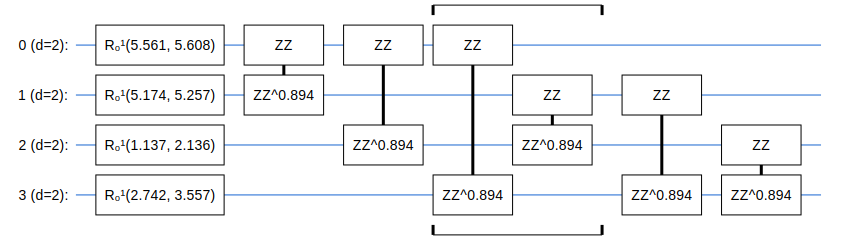

In [ ]:
def qubit_parameters_reshape(params):
        # Parameters reshape
        tl = np.array([params[:num_qubits]])
        pl = np.array([params[num_qubits : 2 * num_qubits]])
        tqtl = np.array([params[-1]])

        return tl, pl, tqtl

num_qubits = 4
num_layers = 1

params = np.random.uniform(low=0, high=2 * np.pi, size= num_qubits * 2 + 1)
print(f'params = {params}')
print()
tl, pl, tqtl = qubit_parameters_reshape(params)
print(f'theta_list = {tl}')
print(f'phi_list = {pl}')
print(f'tqt_list = {tqtl}')

qubit__vqc = qubit_variational_qc(tl, pl, tqtl, num_layers, num_qubits, measurement=False, with_noise=False)
SVGCircuit(qubit__vqc)

params = [5.81964593 3.81535109 6.209131   0.70804921 2.0810108  6.21030419
 5.08150345 3.87402709 2.80973932 3.01027104 3.47351558 0.89892145
 1.60564468]

theta_list = [array([[5.81964593, 3.81535109],
       [6.209131  , 0.70804921],
       [2.0810108 , 6.21030419]])]
phi_list = [array([[5.08150345, 3.87402709],
       [2.80973932, 3.01027104],
       [3.47351558, 0.89892145]])]
tqt_list = [array([1.60564468])]



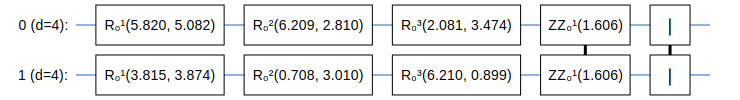

In [ ]:
def qudit_parameters_reshape(params):
    tl = [params[:num_qudits * 3].reshape((3, num_qudits))]
    pl = [params[num_qudits * 3:2 * num_qudits * 3].reshape((3, num_qudits))]
    tqtl = [params[2 * num_qudits * 3:]]

    return tl, pl, tqtl

num_qudits = 2
num_layers = 1

params = np.random.uniform(low=0, high=2 * np.pi, size= num_qudits * 6 + 1)
print(f'params = {params}')
print()
tl, pl, tqtl = qudit_parameters_reshape(params)
print(f'theta_list = {tl}')
print(f'phi_list = {pl}')
print(f'tqt_list = {tqtl}')
print()
qudit__vqc = variational_qc(tl, pl, tqtl, num_layers, num_qudits, measurement=False, with_noise=False)
SVGCircuit(qudit__vqc)

## Ising problem instanse


\begin{equation}
    H =  - J\sum\limits_i {S_i^zS_{i + 1}^z - B\sum\limits_i {S_i^x} }
\end{equation}

\begin{equation}
    S = -1, 1
\end{equation}

\begin{equation}
    H =  - \frac{J}{4}\sum\limits_i {\sigma_i^z\sigma_{i + 1}^z - \frac{B}{2}\sum\limits_i {\sigma_i^x} }
\end{equation}

\begin{equation}
    \sigma = 0, 1
\end{equation}

Create Ising interaction matrix

In [ ]:
n_qubits = 4
qubits = [cirq.LineQubit(i) for i in range(n_qubits)]

J = np.zeros((n_qubits, n_qubits))

for i in range(n_qubits):
    J[i][(i + 1) % n_qubits] = -1 # np.random.rand()

J

array([[ 0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0., -1.],
       [-1.,  0.,  0.,  0.]])

Objective function that takes a list of variational parameters and returns Ising energy

In [ ]:
def ising_hamiltonian(B):    
    hamiltonian = 0
    for q in qubits:
        hamiltonian += -0.5 * float(B) * cirq.X(q)
    for i1 in range(len(qubits)):
        hamiltonian += -0.25 * cirq.Z(qubits[i1]) * cirq.Z(qubits[(i1 + 1) % n_qubits])
    
    return hamiltonian

print(ising_hamiltonian(0))

-0.250*Z(q(0))*Z(q(1))-0.250*Z(q(1))*Z(q(2))-0.250*Z(q(2))*Z(q(3))-0.250*Z(q(0))*Z(q(3))


In [ ]:
initial_statevector = np.zeros(16, dtype='complex')
initial_statevector[0] += 1

In [ ]:
def objective_function(params, J, B, num_qubits, dimension, sv, show_qc=False, with_noise=False):

    if dimension == 2:
        tl, pl, tqtl = qubit_parameters_reshape(params)
        vqe_circuit = qubit_variational_qc(tl, pl, tqtl, 1, num_qubits, measurement=False, with_noise=with_noise)

    elif dimension == 4:
        tl, pl, tqtl = qudit_parameters_reshape(params)
        vqe_circuit = variational_qc(tl, pl, tqtl, 1, num_qudits, measurement=False, with_noise=with_noise)

    if show_qc:
        print(vqe_circuit)

    #Simulate
    sv = simulator.simulate(vqe_circuit, initial_state=sv).final_state_vector
    qmap = {q:i for i, q in enumerate(qubits)}
    expectation = ising_hamiltonian(B).expectation_from_state_vector(sv, qmap).real

    return expectation / 4

qubits

In [ ]:
num_layers = 1  # number of variational layers
num_qubits = 4
dimension = 2

B = 0
params = np.random.uniform(low=0, high=2 * np.pi, size= num_qubits * 2 + 1)
objective_function(params, J, B, num_qubits, dimension, initial_statevector, show_qc=True)

                                                        ┌──────────────────┐
0 (d=2): ───R₀¹(3.651, 0.962)───ZZ──────────ZZ───────────ZZ────────────────────────────────────────────
                                │           │            │
1 (d=2): ───R₀¹(2.420, 4.721)───ZZ^-0.949───┼────────────┼────────ZZ───────────ZZ──────────────────────
                                            │            │        │            │
2 (d=2): ───R₀¹(4.873, 5.459)───────────────ZZ^-0.949────┼────────ZZ^-0.949────┼───────────ZZ──────────
                                                         │                     │           │
3 (d=2): ───R₀¹(5.902, 0.006)────────────────────────────ZZ^-0.949─────────────ZZ^-0.949───ZZ^-0.949───
                                                        └──────────────────┘


0.0079006003215909

qudits

In [ ]:
num_layers = 1
num_qudits = 2
dimension = 4

B = 0
params = np.random.uniform(low=0, high=2 * np.pi, size= num_qudits * 6 + 1)
objective_function(params, J, B, num_qudits, dimension, initial_statevector, show_qc=True)

0 (d=4): ───R₀¹(5.196, 0.445)───R₀²(1.444, 3.216)───R₀³(0.962, 4.969)───ZZ₀¹(4.230)───|───
                                                                        │             │
1 (d=4): ───R₀¹(1.285, 3.159)───R₀²(1.005, 5.807)───R₀³(5.417, 2.406)───ZZ₀¹(4.230)───|───


0.0011045080609619617

##Optimization - No noise

VQE train function

In [ ]:
def train(b_field, max_layers, n_qubits, dimension, n_initial, verbose=False, with_noise=False):
    
    layers_energy = []
    sv = initial_statevector
    
    for layer in range(1, max_layers + 1):

        cost_energy = []
        angles = []
        
        if verbose:
            print(f'B = {b_field}, layer = {layer}')

        for ii in range(n_initial):
            #print counter
            
            # randomly initialize variational parameters within appropriate bounds
            np.random.seed(ii)
            if dimension == 2:
                params_size = num_qubits * 2 + 1
            elif dimension == 4:
                params_size = num_qudits * 6 + 1
            
            #initial params
            if ii == 0:
                params0 = np.zeros(params_size).tolist()
            else:
                params0 = np.random.uniform(low=0, high=2 * np.pi, size=params_size).tolist()

            bnds = [(0, 2 * np.pi) for _ in range(int(len(params0)))]

            # run classical optimization
            if dimension == 2:
                result = minimize(objective_function, params0, args=(J, b_field, num_qubits, dimension, sv), 
                            method='Nelder-Mead', bounds=bnds, options={'maxiter': 100})
            elif dimension == 4:
                result = minimize(objective_function, params0, args=(J, b_field, num_qudits, dimension, sv), 
                            method='Nelder-Mead', bounds=bnds, options={'maxiter': 100})
            

            # store result of classical optimization
            result_energy = result.fun
            cost_energy.append(result_energy)
            result_angle = result.x
            angles.append(result_angle)
        
        # store energy minimum (over different initial configurations)
        energy_min = np.min(cost_energy)
        optim_angles = angles[np.argmin(cost_energy)]
        if verbose:
            print()
            print('Energy per initial seeds:', cost_energy)
            print('Best energy:', energy_min)
            print('Best angles:', optim_angles)
            print()
        
        layers_energy.append(energy_min)
        
        # Parameters reshape
        if dimension == 2:
            tl, pl, tqtl = qubit_parameters_reshape(optim_angles)
            vqe_circuit = qubit_variational_qc(tl, pl, tqtl, 1, num_qubits, measurement=False, with_noise=with_noise)
        elif dimension == 4:
            tl, pl, tqtl = qudit_parameters_reshape(optim_angles)
            vqe_circuit = variational_qc(tl, pl, tqtl, 1, num_qudits, measurement=False, with_noise=with_noise)
        
        # VQE circuit simulation-
        sv = simulator.simulate(vqe_circuit, initial_state=sv).final_state_vector
        
    return layers_energy

Some settings

In [ ]:
max_layers = 7
n_initial = 30
verbose = True

Linspace of B values for optimization

In [ ]:
B_values = 2 ** np.linspace(0, 3, 7) - 1
B_values

array([0.        , 0.41421356, 1.        , 1.82842712, 3.        ,
       4.65685425, 7.        ])

### Exact numerical solution

We can numerically solve for GS energy of TIM

In [ ]:
def exact_solution(B):

    if B == 0:
        return -0.25

    l_value = 1 / (2 * B)
    gs_energy = 0
    
    # numerical integration
    step_size = 0.0001
    k_values = np.arange(0, np.pi, step_size)
    integration_values = [step_size * np.sqrt(1 + l_value ** 2 + 2 * l_value * np.cos(ki)) for ki in k_values]
    integral = np.sum(integration_values)
    gs_energy = 1 * integral / (4 * np.pi*l_value)
    
    return -1 * gs_energy

In [ ]:
results_exact = [exact_solution(B) for B in B_values]

### Classical optimization qubits d = 2
 

In [ ]:
num_qubits = 4
dimension = 2

In [ ]:
variational_results = []

for B in B_values:
    result = train(B, max_layers, num_qubits, dimension, n_initial,
                verbose=verbose)
    variational_results.append(result)

    print(f'B = {B}')
    print(result)
    print()

B = 0.0, layer = 1

Energy per initial seeds: [-0.25, -0.24999985098838806, -0.08092736778780818, -0.24994639307260513, -0.24665812775492668, -0.247261893004179, -0.24960225075483322, -0.05530989170074463, -0.24999823421239853, -0.006875939667224884, -0.24995550140738487, -0.0005312599241733551, -0.24974913895130157, -0.25, -0.24999984353780746, -0.24408966302871704, -0.02366766333580017, -0.1661054715514183, -0.24639972671866417, -0.2479158341884613, -0.25, -0.25, -0.23567554354667664, -0.24758049845695496, -0.249999787658453, -0.24230780825018883, -0.249539565294981, -0.24789473041892052, -0.22984212264418602, -0.24999400973320007]
Best energy: -0.25
Best angles: [0. 0. 0. 0. 0. 0. 0. 0. 0.]

B = 0.0, layer = 2

Energy per initial seeds: [-0.25, -0.24999985098838806, -0.08092736778780818, -0.24994639307260513, -0.24665812775492668, -0.247261893004179, -0.24960225075483322, -0.05530989170074463, -0.24999823421239853, -0.006875939667224884, -0.24995550140738487, -0.0005312599241733551,

### Classical optimization qudits d = 4
 

In [ ]:
num_qudits = 2
dimension = 4

In [ ]:
qudit_variational_results = []

for B in B_values:
    result = train(B, max_layers, num_qudits, dimension, n_initial,
                verbose=verbose)
    qudit_variational_results.append(result)

    print(f'B = {B}')
    print(result)
    print()

B = 0.0, layer = 1

Energy per initial seeds: [-0.25, -0.18605443835258484, 0.00025171786546707153, 1.2114644050598145e-05, -0.22510788589715958, -0.2217925451695919, -0.19731394946575165, 0.0021559949964284897, -0.18840012326836586, -0.00017248187214136124, -0.1991736888885498, -0.09786016028374434, -0.23051461577415466, -0.15559653379023075, -0.13904719427227974, -0.22739285230636597, -0.21946924179792404, -0.11913051456212997, -0.0257595032453537, -0.16377578489482403, -0.2473757378757, -0.21155166998505592, -0.06145183276385069, -2.7939677238464355e-09, -0.21171724796295166, -0.026260722428560257, -0.16243021003901958, -0.19356859102845192, -0.2407292202115059, -0.24036845937371254]
Best energy: -0.25
Best angles: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

B = 0.0, layer = 2

Energy per initial seeds: [-0.25, -0.18605443835258484, 0.00025171786546707153, 1.2114644050598145e-05, -0.22510788589715958, -0.2217925451695919, -0.19731394946575165, 0.0021559949964284897, -0.188400123268365

##Result log

In [ ]:
variational_results_filename = "variational_results.csv"
qudit_variational_results_filename = "qudit_variational_results.csv"

In [ ]:
np.savetxt(variational_results_filename, variational_results, delimiter=",")
np.savetxt(qudit_variational_results_filename, qudit_variational_results, delimiter=",")

In [ ]:
variational_results = np.genfromtxt(variational_results_filename, delimiter=',')
qudit_variational_results = np.genfromtxt(qudit_variational_results_filename, delimiter=',')

variational_results

array([[-0.25      , -0.25      , -0.25      , -0.25      , -0.25      ,
        -0.25      , -0.25      ],
       [-0.28118183, -0.28739836, -0.2898397 , -0.29091179, -0.2910833 ,
        -0.2917469 , -0.2919464 ],
       [-0.49197621, -0.49321989, -0.49386491, -0.49439269, -0.49684925,
        -0.49770002, -0.49788387],
       [-0.85647432, -0.89617888, -0.91371665, -0.91491489, -0.9149885 ,
        -0.91501288, -0.91503299],
       [-1.43035599, -1.47315782, -1.4932872 , -1.49910098, -1.50046114,
        -1.50163384, -1.50187803],
       [-2.17645913, -2.28572818, -2.30810496, -2.32316198, -2.32740292,
        -2.32749187, -2.3274925 ],
       [-3.30510336, -3.47054043, -3.4907986 , -3.49742018, -3.5009299 ,
        -3.50094868, -3.50116452]])

## Comparison of exact and variational solutions

precomputed values

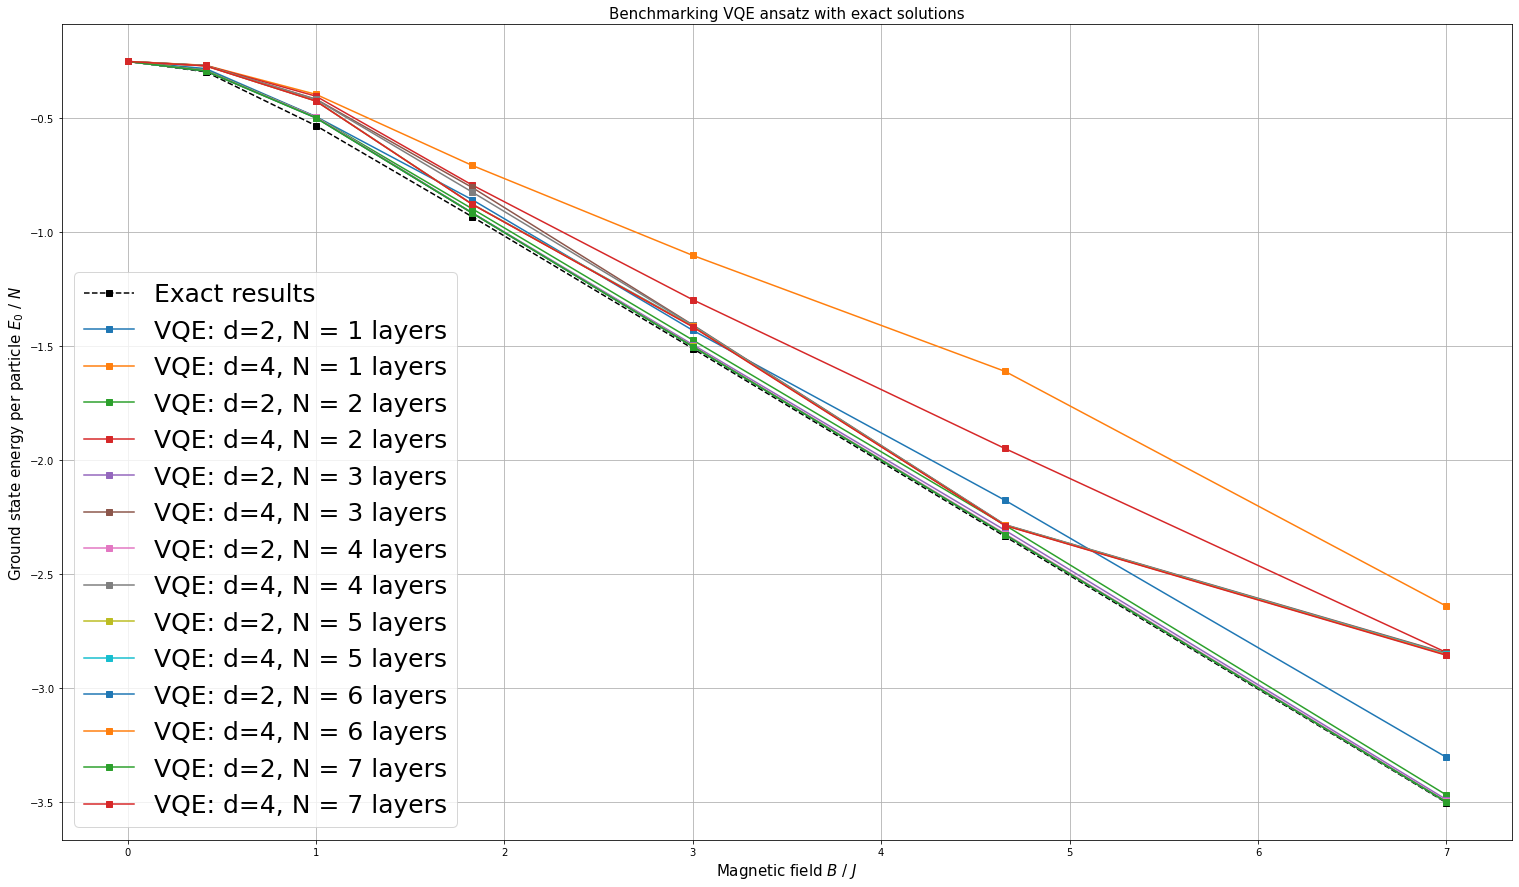

In [ ]:
plt.figure(figsize=(26, 15))

plt.plot(B_values, results_exact, 'k--s', label='Exact results')

for n_layers in range(1, max_layers + 1):
    plt.plot(B_values, [result[n_layers - 1] for result in variational_results], '-s', label=f'VQE: d=2, N = {n_layers} layers')
    plt.plot(B_values, [result[n_layers - 1] for result in qudit_variational_results], '-s', label=f'VQE: d=4, N = {n_layers} layers')

plt.title('Benchmarking VQE ansatz with exact solutions', fontsize=15)
plt.xlabel(r'Magnetic field $B$ / $J$ ', fontsize=15)
plt.ylabel('Ground state energy per particle $E_{0}$ / $N$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)

plt.savefig('vqe_qubits.png')

Relative error of VQE algorithm

\begin{equation}
    \eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|
\end{equation}

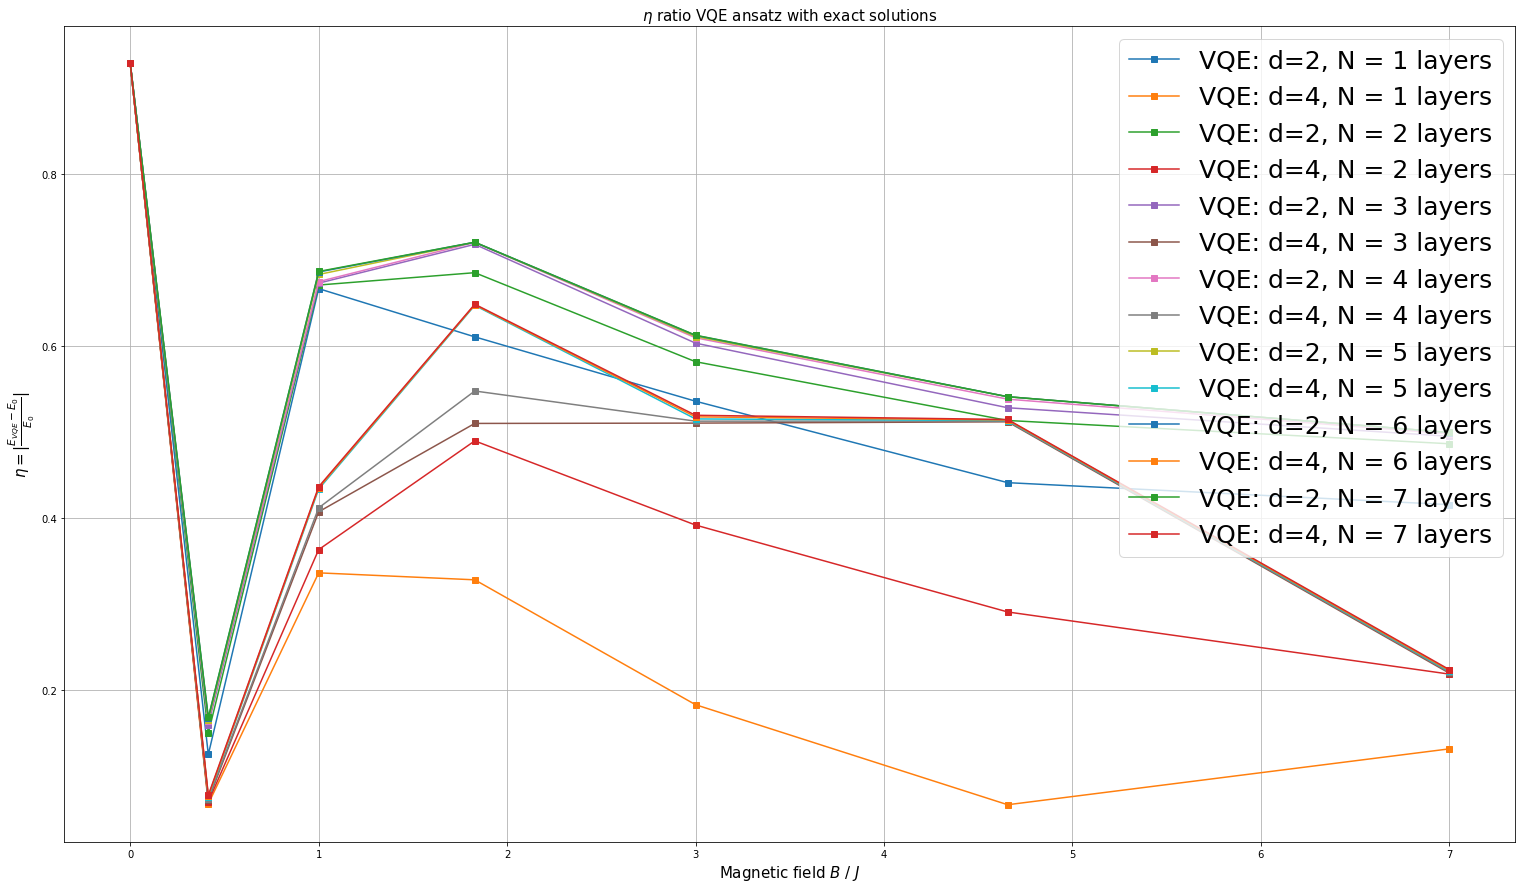

In [ ]:
plt.figure(figsize=(26, 15))

for n_layers in range(1, max_layers + 1):
    qubit_eta = []
    for i in range(len(B_values)):
        qubit_eta = qubit_eta + [np.abs(([result[n_layers - 1] for result in variational_results][i] - results_exact[i - 1]) / results_exact[i - 1]) ]
    plt.plot(B_values, qubit_eta, '-s', label=f'VQE: d=2, N = {n_layers} layers')


    qudit_eta = []
    for i in range(len(B_values)):
        qudit_eta = qudit_eta + [np.abs(([result[n_layers - 1] for result in qudit_variational_results][i] - results_exact[i - 1]) / results_exact[i - 1]) ]
    plt.plot(B_values, qudit_eta, '-s', label=f'VQE: d=4, N = {n_layers} layers')

plt.title(r'$\eta$ ratio VQE ansatz with exact solutions', fontsize=15)
plt.xlabel(r'Magnetic field $B$ / $J$ ', fontsize=15)
plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)

plt.savefig('vqe_eta.png')

### Layerwise progress:



In [ ]:
qubit_layer_score = []

for result in variational_results[-1]:
    eta = np.abs((result - results_exact[-1]) / results_exact[-1])  
    qubit_layer_score.append(eta)

qudit_layer_score = []

for result in qudit_variational_results[-1]:
    eta = np.abs((result - results_exact[-1]) / results_exact[-1])  
    qudit_layer_score.append(eta)


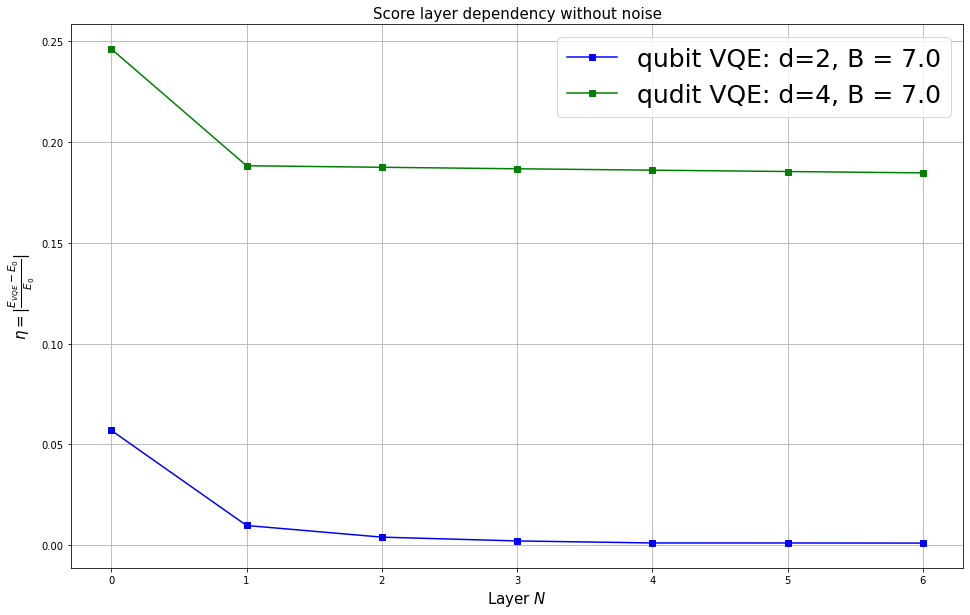

In [ ]:
plt.figure(figsize=(16, 10))

x = list(range(len(qubit_layer_score)))

plt.plot(x, qubit_layer_score, '-sb', label=f'qubit VQE: d=2, B = {B_values[-1]}')
plt.plot(x, qudit_layer_score, '-sg', label=f'qudit VQE: d=4, B = {B_values[-1]}')

plt.title(r'Score layer dependency without noise', fontsize=15)
plt.xlabel(r'Layer $N$', fontsize=15)
plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)

plt.savefig('score_layer_dependency.png')

### Layerwise loop 

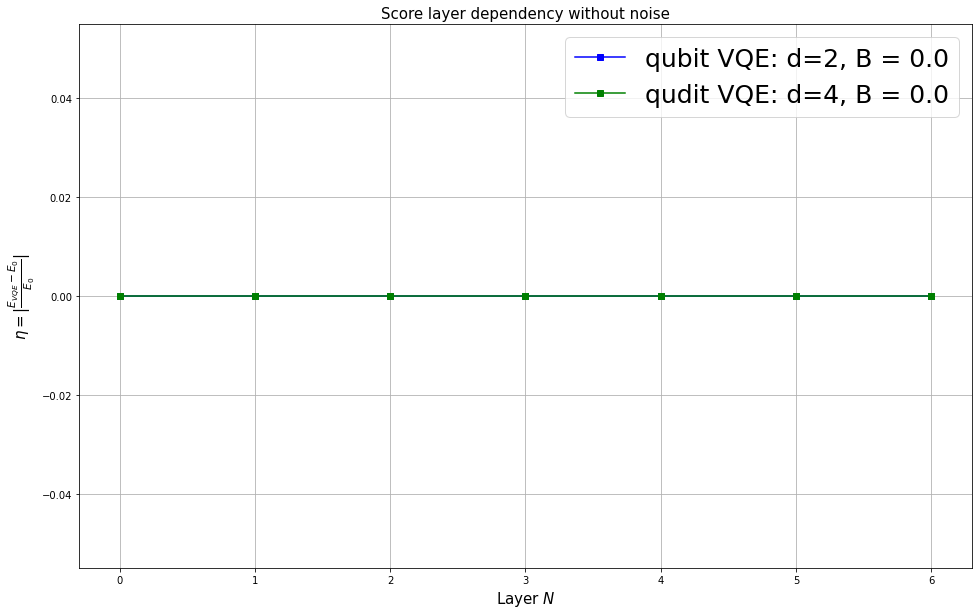

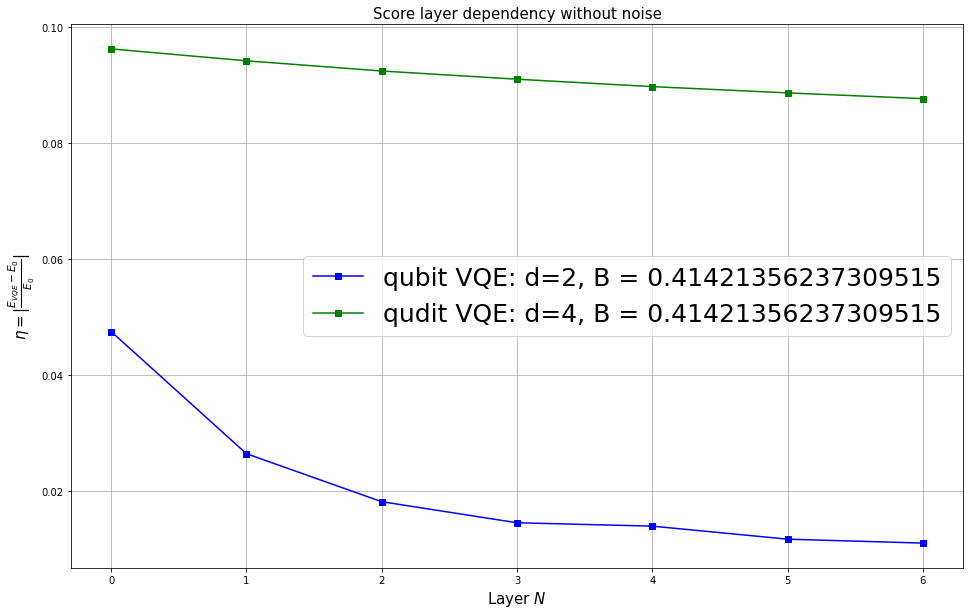

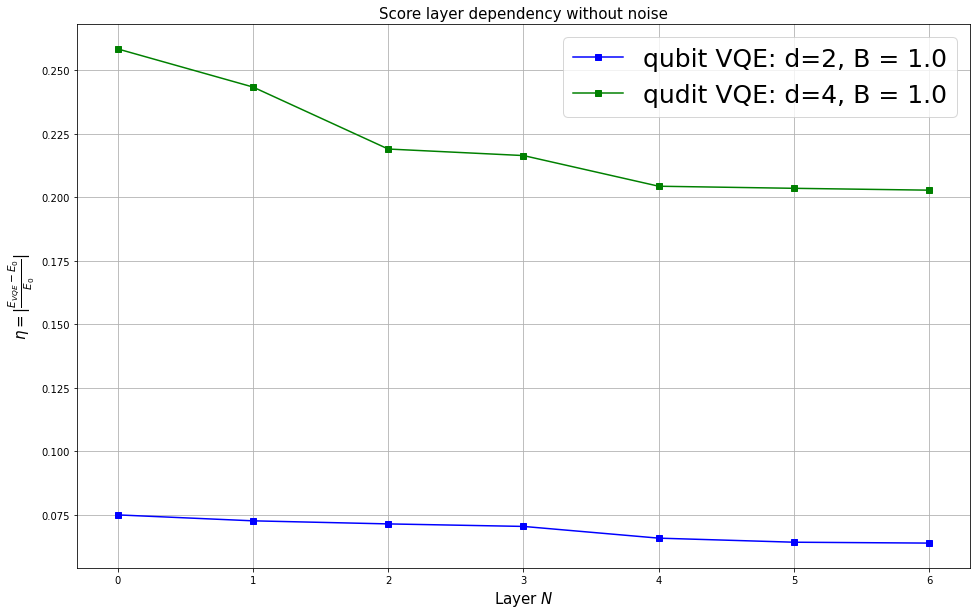

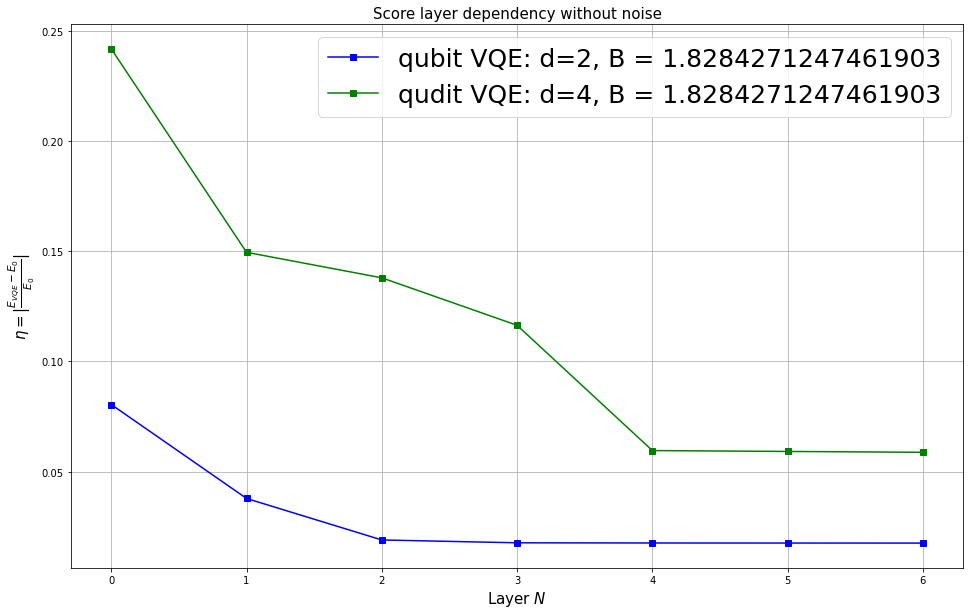

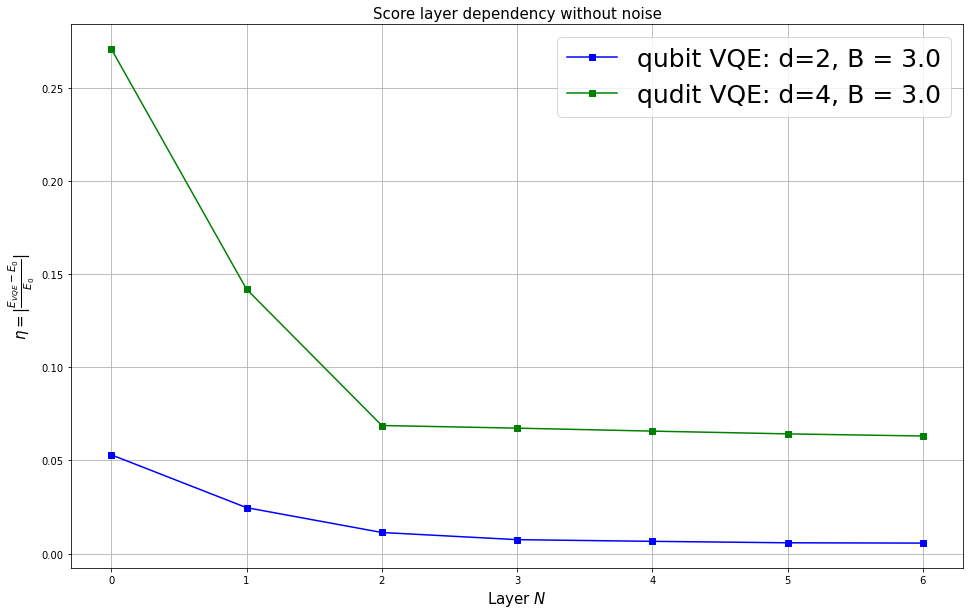

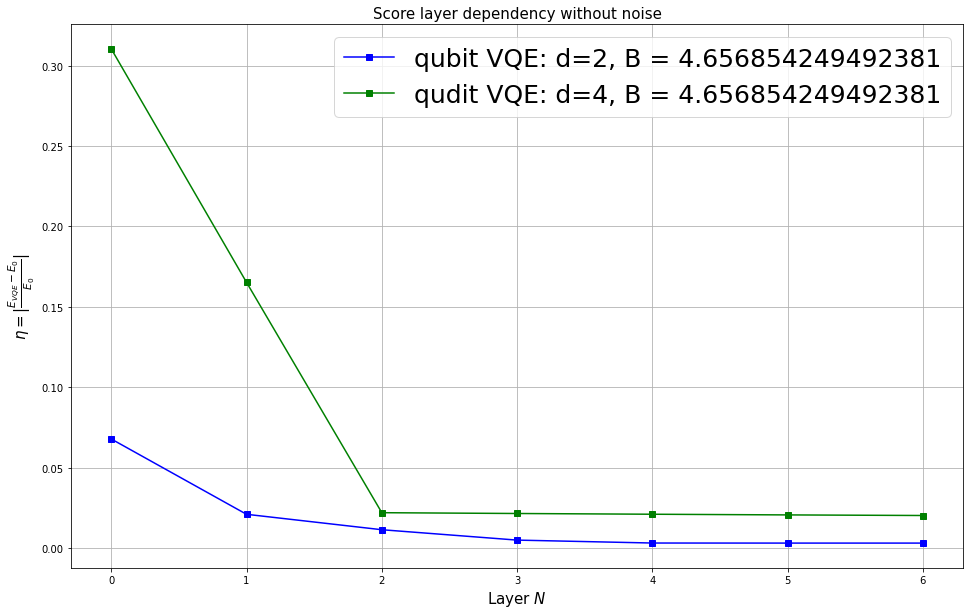

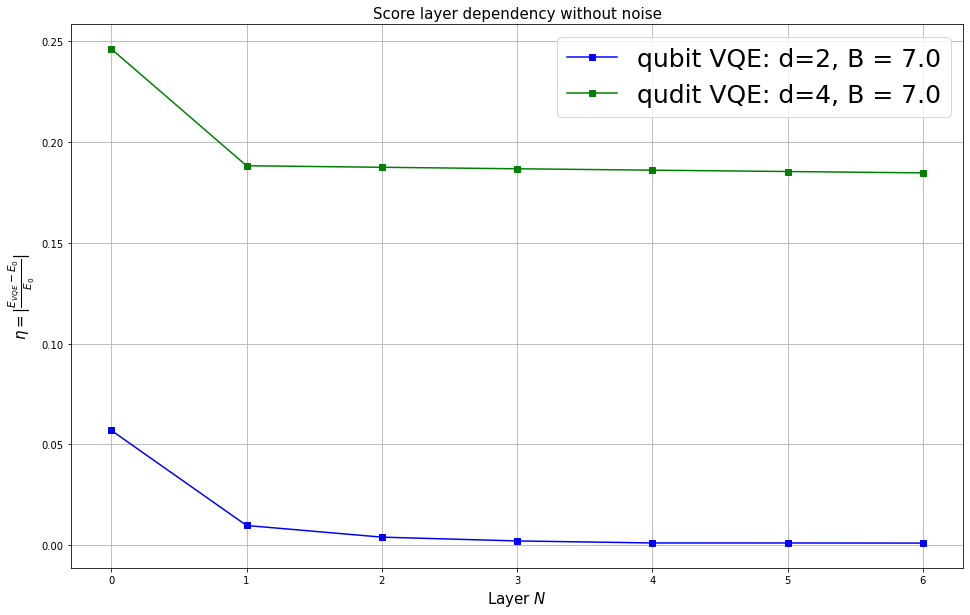

In [ ]:
for B_value_index in range(len(B_values)):
    qubit_layer_score = []

    for result in variational_results[B_value_index]:
        eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
        qubit_layer_score.append(eta)

    qudit_layer_score = []

    for result in qudit_variational_results[B_value_index]:
        eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
        qudit_layer_score.append(eta)


    plt.figure(figsize=(16, 10))

    x = list(range(len(qubit_layer_score)))

    plt.plot(x, qubit_layer_score, '-sb', label=f'qubit VQE: d=2, B = {B_values[B_value_index]}')
    plt.plot(x, qudit_layer_score, '-sg', label=f'qudit VQE: d=4, B = {B_values[B_value_index]}')

    plt.title(r'Score layer dependency without noise', fontsize=15)
    plt.xlabel(r'Layer $N$', fontsize=15)
    plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
    plt.grid()
    plt.legend(fontsize=25)

##Single parameter dependence

In [ ]:
def train_with_parameters_saved(b_field, max_layers, n_qubits, dimension, n_initial, verbose=False, with_noise=False):
    
    layers_energy = []
    layers_parameters = []

    sv = initial_statevector
    
    for layer in range(1, max_layers + 1):

        cost_energy = []
        angles = []
        
        if verbose:
            print(f'B = {b_field}, layer = {layer}')

        for ii in range(n_initial):
            #print counter
            
            # randomly initialize variational parameters within appropriate bounds
            np.random.seed(ii)
            if dimension == 2:
                params_size = num_qubits * 2 + 1
            elif dimension == 4:
                params_size = num_qudits * 6 + 1
            
            #initial params
            if ii == 0:
                params0 = np.zeros(params_size).tolist()
            else:
                params0 = np.random.uniform(low=0, high=2 * np.pi, size=params_size).tolist()

            bnds = [(0, 2 * np.pi) for _ in range(int(len(params0)))]

            # run classical optimization
            if dimension == 2:
                result = minimize(objective_function, params0, args=(J, b_field, num_qubits, dimension, sv), 
                            method='Nelder-Mead', bounds=bnds, options={'maxiter': 100})
            elif dimension == 4:
                result = minimize(objective_function, params0, args=(J, b_field, num_qudits, dimension, sv), 
                            method='Nelder-Mead', bounds=bnds, options={'maxiter': 100})
            

            # store result of classical optimization
            result_energy = result.fun
            cost_energy.append(result_energy)
            result_angle = result.x
            angles.append(result_angle)
        
        # store energy minimum (over different initial configurations)
        energy_min = np.min(cost_energy)
        optim_angles = angles[np.argmin(cost_energy)]
        if verbose:
            print()
            print('Energy per initial seeds:', cost_energy)
            print('Best energy:', energy_min)
            print('Best angles:', optim_angles)
            print()
        
        layers_energy.append(energy_min)
        layers_parameters.append(optim_angles)
        
        # Parameters reshape
        if dimension == 2:
            tl, pl, tqtl = qubit_parameters_reshape(optim_angles)
            vqe_circuit = qubit_variational_qc(tl, pl, tqtl, 1, num_qubits, measurement=False, with_noise=with_noise)
        elif dimension == 4:
            tl, pl, tqtl = qudit_parameters_reshape(optim_angles)
            vqe_circuit = variational_qc(tl, pl, tqtl, 1, num_qudits, measurement=False, with_noise=with_noise)
        
        # VQE circuit simulation-
        sv = simulator.simulate(vqe_circuit, initial_state=sv).final_state_vector
        
    return layers_energy, layers_parameters

In [ ]:
B = 3.323412
max_layers = 6
num_qubits = 4
dimension = 2
n_initial = 7
verbose = True

single_result_energy, single_result_parameters = train_with_parameters_saved(B, max_layers, num_qubits, dimension, n_initial, verbose=verbose)

B = 3.323412, layer = 1

Energy per initial seeds: [-0.40646644446418434, -0.8095373195081759, -1.3259788488852828, -0.882270838714525, -0.7297090697778471, -1.1157558996558803, -0.7726130267440562]
Best energy: -1.3259788488852828
Best angles: [1.36871987 0.18363615 1.42322911 4.79525522 1.68132105 1.70245194
 1.64371099 4.7430977  2.00130917]

B = 3.323412, layer = 2

Energy per initial seeds: [-1.3562822204720972, -0.6605503133567869, -1.3342100183916017, -1.6217950124556717, -1.6388059625755325, -1.6452323882102482, -1.6319515324185787]
Best energy: -1.6452323882102482
Best angles: [1.39791877 4.83666359 1.01317244 6.13105438 3.12682445 4.72770015
 3.04465329 3.77013647 2.00712557]

B = 3.323412, layer = 3

Energy per initial seeds: [-1.6459987229309156, -0.5006290375735349, -1.641882411701558, -1.6484389413068443, -1.641682380285937, -1.6540597887183799, -1.6445424243458509]
Best energy: -1.6540597887183799
Best angles: [1.51853579 5.65968661 0.81422106 5.45548463 3.33977294 3.108

In [ ]:
single_result_parameters

[array([1.36871987, 0.18363615, 1.42322911, 4.79525522, 1.68132105,
        1.70245194, 1.64371099, 4.7430977 , 2.00130917]),
 array([1.39791877, 4.83666359, 1.01317244, 6.13105438, 3.12682445,
        4.72770015, 3.04465329, 3.77013647, 2.00712557]),
 array([1.51853579, 5.65968661, 0.81422106, 5.45548463, 3.33977294,
        3.10803444, 6.23917133, 3.12158616, 1.99414048]),
 array([6.23984703, 1.92814939, 5.46696209, 0.28191013, 0.69656199,
        3.16934744, 3.32436231, 2.6665847 , 1.9997302 ]),
 array([1.72697735, 6.18349317, 0.36032682, 2.27218514, 3.18260497,
        3.84127211, 6.27526541, 3.15016229, 2.00161322]),
 array([6.22343721, 6.22137992, 6.25245032, 6.26714084, 1.47032935,
        0.87248397, 4.8315016 , 0.0253314 , 1.99243088])]

output

In [ ]:
base_vqc = qubit_variational_qc(*qubit_parameters_reshape(single_result_parameters[0]), 1, 4)

for i in range(1, len(single_result_parameters) - 1):
    base_vqc.append(qubit_variational_qc(*qubit_parameters_reshape(single_result_parameters[i]), 1, 4))

base_vqc

┌────────────┐                                                               ┌────────────────┐                                                                     ┌──────────────────┐                                                             ┌────────┐                                                           ┌────────────────┐
0 (d=2): ───R₀¹(1.369, 1.681)───ZZ───────ZZ────────ZZ────────────────────────────────R₀¹(1.398, 3.127)───ZZ─────────ZZ──────────ZZ────────────────────────────────────────R₀¹(1.519, 3.340)───ZZ──────────ZZ───────────ZZ────────────────────────────────────────────R₀¹(6.240, 0.697)───ZZ─────ZZ──────ZZ────────────────────────R₀¹(1.727, 3.183)───ZZ─────────ZZ──────────ZZ────────────────────────────────────────
                                │        │         │                                                     │          │           │                                                             │           │            │                                                                 │      │       │                                             │          │           │
1 (d=2): ───R₀¹(0.184, 1.702)───ZZ^(0)───┼─────────┼─────ZZ────────ZZ────────────────R₀¹(4.837, 4.728)───ZZ^0.007───┼───────────┼───────ZZ──────────ZZ────────────────────R₀¹(5.660, 3.108)───ZZ^-0.006───┼────────────┼────────ZZ───────────ZZ──────────────────────R₀¹(1.928, 3.169)───ZZ^0───┼───────┼───ZZ──────ZZ────────────R₀¹(6.183, 3.841)───ZZ^0.002───┼───────────┼───────ZZ──────────ZZ────────────────────
                                         │         │     │         │                                                │           │       │           │                                                     │            │        │            │                                                  │       │   │       │                                            │           │       │           │
2 (d=2): ───R₀¹(1.423, 1.644)────────────ZZ^(0)────┼─────ZZ^(0)────┼────────ZZ───────R₀¹(1.013, 3.045)──────────────ZZ^0.007────┼───────ZZ^0.007────┼──────────ZZ─────────R₀¹(0.814, 6.239)───────────────ZZ^-0.006────┼────────ZZ^-0.006────┼───────────ZZ──────────R₀¹(5.467, 3.324)──────────ZZ^0────┼───ZZ^0────┼──────ZZ─────R₀¹(0.360, 6.275)──────────────ZZ^0.002────┼───────ZZ^0.002────┼──────────ZZ─────────
                                                   │               │        │                                                   │                   │          │                                                       │                     │           │                                              │           │      │                                                 │                   │          │
3 (d=2): ───R₀¹(4.795, 4.743)──────────────────────ZZ^(0)──────────ZZ^(0)───ZZ^(0)───R₀¹(6.131, 3.770)──────────────────────────ZZ^0.007────────────ZZ^0.007───ZZ^0.007───R₀¹(5.455, 3.122)────────────────────────────ZZ^-0.006─────────────ZZ^-0.006───ZZ^-0.006───R₀¹(0.282, 2.667)──────────────────ZZ^0────────ZZ^0───ZZ^0───R₀¹(2.272, 3.150)──────────────────────────ZZ^0.002────────────ZZ^0.002───ZZ^0.002───
                                                  └────────────┘                                                               └────────────────┘                                                                     └──────────────────┘                                                             └────────┘                                                           └────────────────┘

In [ ]:
sv_optimal = simulator.simulate(base_vqc).final_state_vector
qmap = {cirq.LineQubit(i): i for i in range(n_qubits)}
ising_hamiltonian(B).expectation_from_state_vector(sv_optimal, qmap).real / 4

-1.6580258141721635

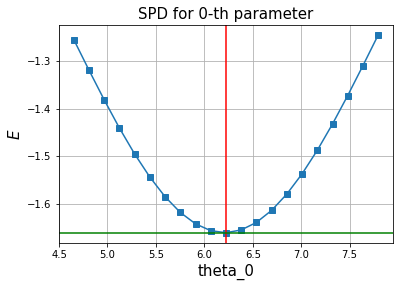

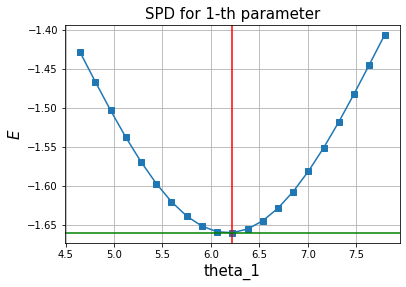

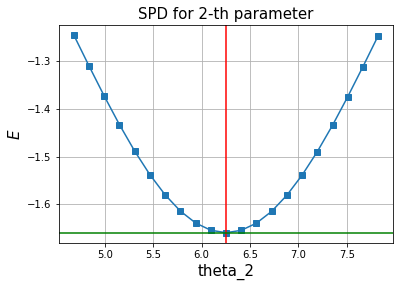

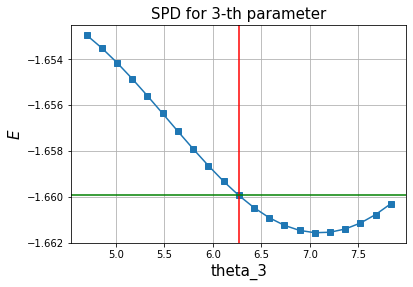

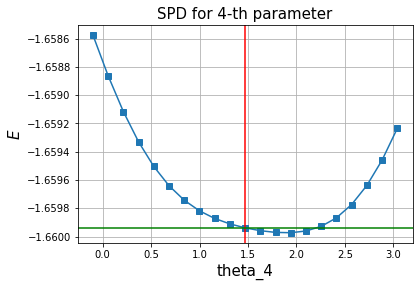

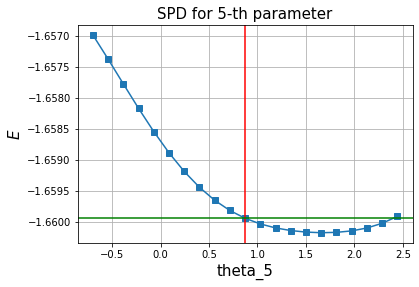

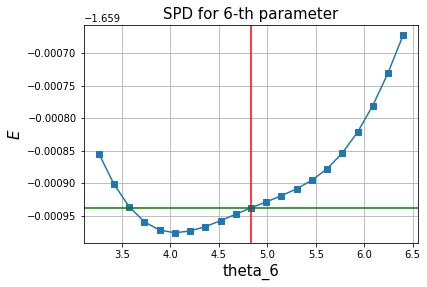

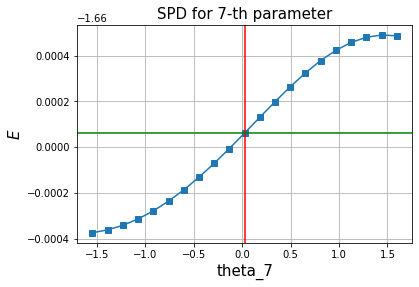

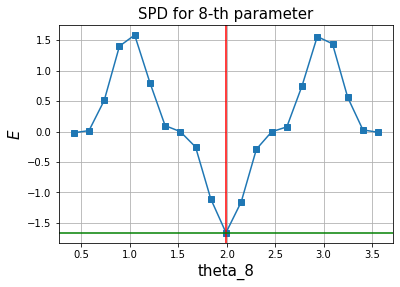

In [ ]:
optimal = np.copy(single_result_parameters[-1])

for par_number in range(len(optimal)):

    optimal = np.copy(single_result_parameters[-1])
    optimal_energy = single_result_energy[-1]

    number_points = 21
    optimal_par = optimal[par_number]

    x = optimal_par * np.ones(number_points) + np.linspace(-np.pi / 2, np.pi / 2, number_points)
    y = []

    for parameter0 in x:
        optimal[par_number] = parameter0

        last_layer = qubit_variational_qc(*qubit_parameters_reshape(optimal), 1, 4)

        vqc_optimal = base_vqc.copy()
        vqc_optimal.append(last_layer)

        sv_optimal = simulator.simulate(vqc_optimal).final_state_vector
        qmap = {q:i for i, q in enumerate(qubits)}
        expectation = ising_hamiltonian(B).expectation_from_state_vector(sv_optimal, qmap).real / 4

        y.append(expectation)


    plt.figure(par_number)
    plt.title(f'SPD for {par_number}-th parameter', fontsize=15)
    plt.xlabel(f'theta_{par_number}', fontsize=15)
    plt.ylabel(f'$E$', fontsize=15)
    plt.grid()
    plt.plot(x, y, '-s', label=f'123')
    plt.axvline(optimal_par, color ='red')
    plt.axhline(optimal_energy, color ='green')